# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission - done
* Add some augmentation transforms (https://github.com/albumentations-team/albumentations)
    * rotation (10 deg)
    * resize
* Extend training epochs

* remove bad data https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/321979



* Go to 2.5 D method

* Go to 3D method




* add Hausdorff metric https://github.com/mavillan/py-hausdorff
https://www.kaggle.com/code/carnozhao/tract-competiton-metrics



In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

#import albumentations as A
from torchvision import transforms


#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

model_name_base = "Unet-4"

# Data

## Process the Metadata

In [2]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv")
display(df2d.head())

,Unnamed: 0,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,...,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,fold
0,0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,...,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
1,1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,...,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
2,2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,...,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
3,3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,...,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
4,4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,...,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0


## Create a Pytorch Dataset

In [3]:
from torchvision.transforms import PILToTensor

In [4]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, joint_transform=None, image_transform=None, mask_transform=None):
        self.df = df
        self.path = path
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
        if self.image_transform:
            img = self.image_transform(img)
            
        if self.mask_transform:
            mask = self.mask_transform(mask)       
        
        if self.joint_transform:            
            image_stack = torch.cat([img, mask], dim=0)
            image_stack = self.joint_transform(image_stack)
            img = image_stack[0:1]
            mask = image_stack[1:4]
        

    
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    


In [5]:
dataset = Dataset_from_df(df2d[df2d['segmentations']],TRAIN_FOLDER)

In [6]:
dataset[665]['image'].max()

tensor(10672, dtype=torch.int32)

In [7]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(d['image'].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(rearrange(d['mask'].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    plt.axis('off')

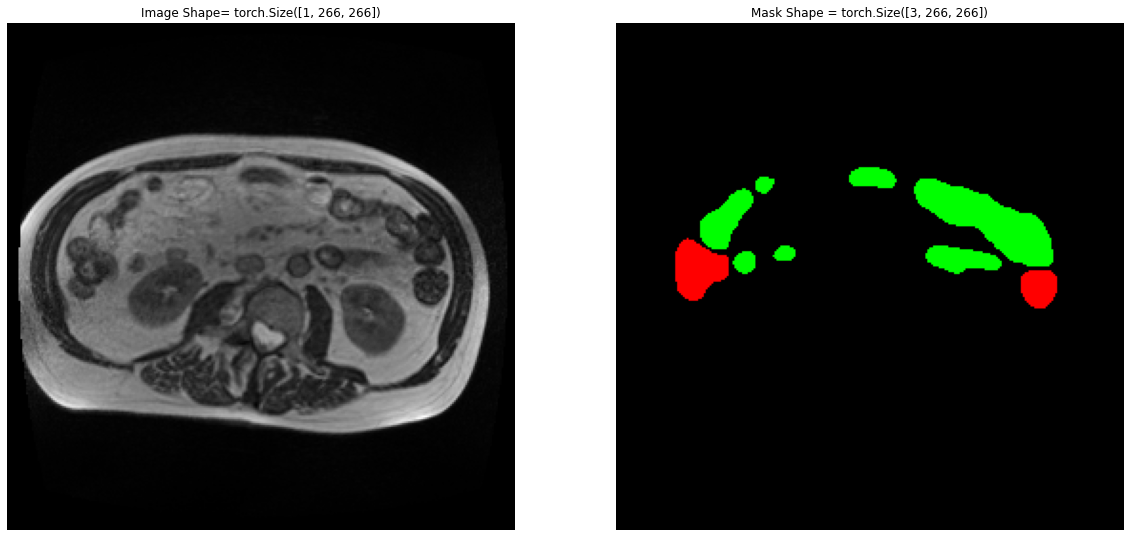

In [8]:
plot_data(dataset[665])

### With n fold cross validation we need a dataset for each fold

In [9]:
def prepare_datasets(df, fold, train_transforms, scale_transforms):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER, joint_transform=train_transforms,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER, joint_transform=None,
                                   image_transform=scale_transforms, mask_transform=scale_transforms)
    
    return train_dataset, valid_dataset

# Training

In [10]:
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

## Loss Functions and Metrics

In [11]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Training Loops

In [12]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [13]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        
        with torch.no_grad():
            output = model(images)
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## UNET3+

https://github.com/PedroAltamirano/UNet3_plus/blob/main/iris.ipynb

In [14]:
from torch import nn
from torch.nn import init

In [15]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('Linear') != -1:
    init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def weights_init_xavier(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.xavier_normal_(m.weight.data, gain=1)
  elif classname.find('Linear') != -1:
    init.xavier_normal_(m.weight.data, gain=1)
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def weights_init_kaiming(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
  elif classname.find('Linear') != -1:
    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def weights_init_orthogonal(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.orthogonal_(m.weight.data, gain=1)
  elif classname.find('Linear') != -1:
    init.orthogonal_(m.weight.data, gain=1)
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
  #print('initialization method [%s]' % init_type)
  if init_type == 'normal':
    net.apply(weights_init_normal)
  elif init_type == 'xavier': #he uniform
    net.apply(weights_init_xavier)
  elif init_type == 'kaiming':
    net.apply(weights_init_kaiming)
  elif init_type == 'orthogonal':
    net.apply(weights_init_orthogonal)
  else:
    raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [16]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

In [17]:
class UNet_3Plus(nn.Module):
  def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
    super(UNet_3Plus, self).__init__()
    self.is_deconv = is_deconv
    self.in_channels = in_channels
    self.is_batchnorm = is_batchnorm
    self.feature_scale = feature_scale

    filters = [64, 128, 256, 512, 1024]

    ## -------------Encoder--------------
    self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

    ## -------------Decoder--------------
    self.CatChannels = filters[0]
    self.CatBlocks = 5
    self.UpChannels = self.CatChannels * self.CatBlocks

    '''stage 4d'''
    # h1->320*320, hd4->40*40, Pooling 8 times
    self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
    self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

    # h2->160*160, hd4->40*40, Pooling 4 times
    self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
    self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

    # h3->80*80, hd4->40*40, Pooling 2 times
    self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
    self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

    # h4->40*40, hd4->40*40, Concatenation
    self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
    self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd4->40*40, Upsample 2 times
    self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
    self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu4d_1 = nn.ReLU(inplace=True)

    '''stage 3d'''
    # h1->320*320, hd3->80*80, Pooling 4 times
    self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
    self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

    # h2->160*160, hd3->80*80, Pooling 2 times
    self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

    # h3->80*80, hd3->80*80, Concatenation
    self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
    self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

    # hd4->40*40, hd4->80*80, Upsample 2 times
    self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd4->80*80, Upsample 4 times
    self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
    self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
    self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu3d_1 = nn.ReLU(inplace=True)

    '''stage 2d '''
    # h1->320*320, hd2->160*160, Pooling 2 times
    self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

    # h2->160*160, hd2->160*160, Concatenation
    self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

    # hd3->80*80, hd2->160*160, Upsample 2 times
    self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

    # hd4->40*40, hd2->160*160, Upsample 4 times
    self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
    self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd2->160*160, Upsample 8 times
    self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
    self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
    self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu2d_1 = nn.ReLU(inplace=True)

    '''stage 1d'''
    # h1->320*320, hd1->320*320, Concatenation
    self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

    # hd2->160*160, hd1->320*320, Upsample 2 times
    self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd3->80*80, hd1->320*320, Upsample 4 times
    self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
    self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd4->40*40, hd1->320*320, Upsample 8 times
    self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
    self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd1->320*320, Upsample 16 times
    self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
    self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

    # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
    self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu1d_1 = nn.ReLU(inplace=True)

    # output
    self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

    # initialise weights
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        init_weights(m, init_type='kaiming')
      elif isinstance(m, nn.BatchNorm2d):
        init_weights(m, init_type='kaiming')

  def forward(self, inputs):
    ## -------------Encoder-------------
    h1 = self.conv1(inputs)  # h1->320*320*64

    h2 = self.maxpool1(h1)
    h2 = self.conv2(h2)  # h2->160*160*128

    h3 = self.maxpool2(h2)
    h3 = self.conv3(h3)  # h3->80*80*256

    h4 = self.maxpool3(h3)
    h4 = self.conv4(h4)  # h4->40*40*512

    h5 = self.maxpool4(h4)
    hd5 = self.conv5(h5)  # h5->20*20*1024

    ## -------------Decoder-------------
    h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
    h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
    h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
    h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
    hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
    hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
        torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

    h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
    h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
    h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
    hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
    hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
    hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
        torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

    h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
    h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
    hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
    hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
    hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
    hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
        torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

    h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
    hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
    hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
    hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
    hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
    hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
        torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

    d1 = self.outconv1(hd1)  # d1->320*320*n_classes
    return d1


## Training

In [18]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        


In [19]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [20]:
train_transforms = transforms.Compose(
    [transforms.RandomRotation(4, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomPerspective(distortion_scale=.2, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
    
    ])

In [21]:
scale_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((320,320),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Training

In [22]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [23]:
for fold in range(0,n_folds):
    
    model = UNet_3Plus(in_channels=1, n_classes=3, feature_scale=4, is_deconv=True, is_batchnorm=True)

    model.cuda()


    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=2,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=2,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999
    
    
    for epoch in range(1, epochs + 1):

        #lr = lr_scheduler.get_last_lr()
        lr = optimizer.param_groups[0]['lr']
        #print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/14816 [00:00<?, ?it/s]

/media/SSD/conda_env/gi-tract/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


KeyboardInterrupt: 

In [ ]:
:::::::::::::::::::::::

### More training

In [ ]:
init_lr = .0001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [ ]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    #Load files from past training to improve apon them
    model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    model.load_state_dict(torch.load(model_in_str))
    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

In [ ]:
::::::::::::::::::::::::: #Stop

## Do some trial inference on the validation set

In [ ]:
model_name_base = "Unet-3"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#encoder_weights=None,
in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

In [ ]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
model.load_state_dict(torch.load(model_in_str))

In [ ]:
train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=8,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [ ]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [ ]:
output = torch.nn.Sigmoid()(output)

In [ ]:
def plot_result(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

In [ ]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)

## Calculate the error metrics on the validation folds

In [ ]:
model_name = "Unet-3-2.pth"
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [ ]:

mean_metric = 0

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, scale_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                      loss_fn,
                                                      metric_fn,
                                                      model)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric/n_folds)    

In [ ]:
torch.cuda.empty_cache()